# Dependency

- MPI v >= 4.0
- libAATM
- The submodules (git init --recursive --update)

In [1]:
# import system packages

import os
from datetime import datetime
import sys
import argparse
import traceback
import pickle
import yaml
from argparse import ArgumentParser, RawTextHelpFormatter

# import numpy
import numpy as np
import healpy as hp

# the MPI comunicator class, customized for pycal data storage
from pycal.mpi import get_world, Comm

# the Data class 
from pycal.dist import distribute_uniform, Data

# some pycal utils to share informations with the environment
from pycal.utils import Logger, Environment, memreport

# some timers
from pycal.timing import function_timer, GlobalTimers, Timer, gather_timers
from pycal.timing import dump as dump_timing

# the simulate the pointing, the atmosphere and put all the information in the TODGround class
from pycal.todmap import TODGround, OpSimAtmosphere, OpPointingHpix
from pycal.weather import Weather

# Some wrapper to libaatm, they solve the radiative transfer equation in local thermodynamic equilibrium
from pycal.todmap.atm import atm_absorption_coefficient, atm_absorption_coefficient_vec

# helper functions
from pycal.tests._helpers import boresight_focalplane
import pycal.qarray as qa

# focal plane and telescope calsses
from pycal.todmap import Focalplane
from pycal.todmap import Telescope

# Timer and Focalplane functions

In [2]:
# set up the output directory for each mc iterations

@function_timer
def setup_output(outdir, comm, mc, freq):
    outpath = "{}/{:08}/{:03}".format(outdir, mc, int(freq))
    if comm.world_rank == 0:
        print("Creating the outpath: {}".format(outpath))
        os.makedirs(outpath, exist_ok=True)
    return outpath

def load_focalplane(args, comm):
    focalplane = None

    # Load focalplane information

    if comm.comm_world is None or comm.comm_world.rank == 0:
        if focalplane is None:
            detector_data = {}
            with open(r'./strip_focal_plane.yaml') as file:
                focalplane=yaml.safe_load(file)

            detecotrs=focalplane['horns'].keys()
            for i in detecotrs:
                directions=focalplane['horns'][i]['orientation']
                l=np.arctan(directions[0]/directions[2])
                u=np.arctan(directions[1]/directions[2])
                zaxis = np.array([0, 0, 1], dtype=np.float64)
                
                angrot = qa.rotation(zaxis, 0 * np.pi / 180.0)
                wx = np.rad2deg(l) * np.pi / 180.0
                wy = np.rad2deg(u) * np.pi / 180.0
                wz = np.sqrt(1.0 - (wx * wx + wy * wy))
                wdir = np.array([wx, wy, wz])
                strip_quat = qa.from_vectors(zaxis, wdir)
                
                strip = {}
                strip["quat"] = strip_quat
                strip["fwhm"] = 20.0
                strip["fknee"] = 0.0
                strip["fmin"] = 1e-9
                strip["alpha"] = 1.0
                strip["NET"] = 1.0
                strip["color"] = "r"
            
                detector_data[i] = strip
            
            focalplane = Focalplane(
                detector_data=detector_data, sample_rate=args.sample_rate
            )
        else:
            focalplane = Focalplane(
                fname_pickle=args.focalplane, sample_rate=args.sample_rate
            )
    if comm.comm_world is not None:
        focalplane = comm.comm_world.bcast(focalplane, root=0)

    if args.debug:
        if comm.comm_world is None or comm.comm_world.rank == 0:
            outfile = "{}/focalplane.png".format(args.outdir)
            focalplane._plot_fp(12, 12, outfile)

    #schedule.telescope.focalplane = focalplane
    #detweights = focalplane.detweights

    return focalplane

# Simulation parameters

In [51]:
class args:
    # Required arguments
    ces_name = "Test-scan"
    ces_start_time = "2022,7,1,0,0,0"
    ces_stop_time = "2022,7,1,3,0,0"
    sample_rate = 20
    el_mode_rate = 0.001
    el_mod_amplitude = 1.0
    el_mod_sine = True
    el_mod_step = 0

    # Scan Parameters
    ces_azmin = 1
    ces_azmax = 359
    ces_el = 70
    scan = "spin"
    subscan = ""
    scanrate = 6.0
    scan_accel = 0.0

    # Load the focalplane "The yaml file"
    focalplane = None

    # Site parameters
    site_name = "Tenerife"
    site_lon = "-16:31:00"
    site_lat =  "28:20:00"
    site_alt = 2390.0
    coord = "C"

    # Map parameters
    CES_star = None
    NSIDE = 128
    debug = True 
    outdir = "out_directory"

    # Atmospheric parameters
    start_mc = 0
    nsimu = 1
    cache_name = "atm_"
    atm_cache = "atm_cache_"
    verbose = 0
    freq = 43.0
    weather_file = "weather_STRIP.fits"

# Parallel logger (gather all the messages from different processes)

In [52]:
# definition of the logger, the global timer and the environment
log = Logger.get()
gt = GlobalTimers.get()
env = Environment.get()

gt.start("Atmospheric simulation (globbal timer)")
timer0 = Timer()
timer0.start()

# Initialize the communicator

In [53]:
# Get the communicator
mpiworld, procs, rank = get_world()
if rank == 0:
    print(env)
if mpiworld is None:
    log.info("Running serially with one process at {}".format(str(datetime.now())))
else:
    if rank == 0:
        log.info(
            "Running with {} processes at {}".format(procs, str(datetime.now()))
        )

comm = Comm(world=mpiworld)
    

<cal.Environment
  Source code version = 0.0.0
  Logging level = INFO
  Handling enabled for 0 signals:
  Max threads = 16
  MPI build enabled
  MPI runtime enabled
>


# Load the focalplane

In [54]:
args.outdir = args.outdir+args.ces_start_time

if comm.world_rank == 0:
    print("Creating the outdir: {}".format(args.outdir))
    os.makedirs(args.outdir, exist_ok=True)

fp = load_focalplane(args, comm)

Creating the outdir: out_directory2022,7,1,0,0,0


# This thread creates the TOD structure

In [55]:
# Create the TOD structure
data = Data(comm)
weather = args.weather_file

sta = str(args.ces_start_time).split(",")
sto = str(args.ces_stop_time).split(",")
start_time = datetime(int(sta[0]), int(sta[1]), int(sta[2]), int(sta[3]), int(sta[4]), int(sta[5])).timestamp()
stop_time = datetime(int(sto[0]), int(sto[1]), int(sto[2]), int(sto[3]), int(sto[4]), int(sto[5])).timestamp()

totsamples = int((stop_time - start_time) * args.sample_rate)

# create the TOD for this observation
if comm.comm_group is not None:
    ndetrank = comm.comm_group.size
else:
    ndetrank = 1

try:
    tod = TODGround(
        comm.comm_group,
        fp.detquats,
        totsamples,
        # detranks=ndetrank,
        firsttime=start_time,
        rate=args.sample_rate,
        site_lon=args.site_lon,
        site_lat=args.site_lat,
        site_alt=args.site_alt,
        azmin=args.ces_azmin,
        azmax=args.ces_azmax,
        el=args.ces_el,
        el_mod_step = args.el_mod_step,
        el_mod_rate=args.el_mode_rate,
        el_mod_amplitude=args.el_mod_amplitude,
        el_mod_sine=args.el_mod_sine,
        scanrate=args.scanrate,
        scan_accel=args.scan_accel,
        cosecant_modulation=True,
        CES_start=None,
        CES_stop=None,
        sun_angle_min=None,
        coord=args.coord,
        sampsizes=None,
        report_timing=None,
        hwprpm=None,
        hwpstep=None,
        hwpsteptime=None,
    )
except RuntimeError as e:
    raise RuntimeError(
        'Failed to create TOD for {}-{}-{}: "{}"'
        "".format(args.ces_name, args.scan, args.subscan, e)
    )

# Create the Observation dictionary

In [56]:
# Create the observation, and append the tod
obs = {}
obs["name"] = "CES-{}-{}-{}-{}".format(
    args.site_name, args.ces_name, args.scan, args.subscan
)
obs["tod"] = tod
obs["id"] = data.comm.group
obs["telescope_id"] = 1
obs["site"] = "Tenerife"
obs["site_name"] = args.site_name
obs["site_id"] = 123
obs["altitude"] = args.site_alt
obs["weather"] = Weather(weather, site=123)
obs["fpradius"] = 10.0
obs["start_time"] = start_time
obs["focalplane"] = fp

data.obs.append(obs)

# Pointing expansion

In [57]:
# Expand the pointing, interpolating the quaternions
if comm.comm_world is not None:
    comm.comm_world.barrier()
timer0.stop()
if comm.world_rank == 0:
    timer0.report("Simulated scans")

if comm.world_rank == 0:
    log.info("Expanding pointing")

pointing = OpPointingHpix(
    nside=128,
    nest=True,
    mode="IQU",
    single_precision=1e-7,
    nside_submap=128,
)

pointing.exec(data)

if comm.comm_world is not None:
    comm.comm_world.barrier()
if comm.world_rank == 0:
    timer0.report_clear("Pointing generation")

poin={}
for i in obs['tod'].local_dets:
    p = obs['tod'].cache.reference("pixels_{}".format(i))
    poin[i]=p
np.savez_compressed(args.outdir+'/pointings', poin)
    
        

# Create the Atmospheric emission
#### Atmospheric parameters

In [58]:
# Atmospheric MC simulation 

for mc in range(args.start_mc, args.start_mc + args.nsimu):

    timer_MC_iter = Timer()
    timer_MC_iter.start()

    log = Logger.get()
    tmr = Timer()
    tmr.start()
    if comm.world_rank == 0 and args.verbose:
        log.info("Simulating atmosphere")
        if args.atm_cache and not os.path.isdir(args.atm_cache):
            try:
                os.makedirs(args.atm_cache)
            except FileExistsError:
                pass

    common_atm_params = {
    "realization": mc,
    "component": 123456,
    "lmin_center": 0.01, # in m?
    "lmin_sigma": 0.001, 
    "lmax_center": 100,   # in m?
    "lmax_sigma": 10,
    "zatm": 40000.0,
    "zmax": 2000.0,
    "xstep": 100.0,
    "ystep": 100.0,
    "zstep": 100.0,
    "nelem_sim_max": 10000,
    "verbosity": 0,
    "gain": 1,
    "z0_center": 2000,
    "z0_sigma": 0,
    "apply_flags": False,
    "common_flag_name": None,
    "common_flag_mask": 255,
    "flag_name": None,
    "flag_mask": 255,
    "report_timing": True,
    "wind_dist": 100,
    "flush": False,
    }

    # Simulate the atmosphere signal
    atm = OpSimAtmosphere(out="atm", cachedir=args.atm_cache, freq=args.freq, **common_atm_params)
    atm.exec(data)

    if comm.comm_world is not None:
       comm.comm_world.barrier()
    tmr.stop()
    if comm.world_rank == 0:
       tmr.report("Atmosphere simulation")


    if comm.world_rank == 0:
            log.info(
                "Processing frequency {}GHz, MC = {}".format(args.freq, mc))

    # Set up the output directory
    mcoffset = args.freq * 1000000
    outpath = setup_output(args.outdir, comm, mc + mcoffset, args.freq)

    cache_name = "atm"
    log = Logger.get()
    if comm.world_rank == 0 and args.verbose:
        log.info("Scaling atmosphere by frequency")
    timer = Timer()
    timer.start()
    for obs in data.obs: # Now we have only one observation
        tod = obs["tod"]
        todcomm = tod.mpicomm

        weather = obs["weather"]
        focalplane = obs["focalplane"]

        start_time = obs["start_time"]
        weather.set(123, mc, start_time)
        altitude = obs["altitude"]
        air_temperature = weather.air_temperature
        surface_pressure = weather.surface_pressure
        pwv = weather.pwv
        # Use the entire processing group to sample the absorption
        # coefficient as a function of frequency
        freqmin = 0
        freqmax = 2 * args.freq
        nfreq = 1001
        freqstep = (freqmax - freqmin) / (nfreq - 1)
        if todcomm is None:
            nfreq_task = nfreq
            my_ifreq_min = 0
            my_ifreq_max = nfreq
        else:
            nfreq_task = int(nfreq // todcomm.size) + 1
            my_ifreq_min = nfreq_task * todcomm.rank
            my_ifreq_max = min(nfreq, nfreq_task * (todcomm.rank + 1))
        my_nfreq = my_ifreq_max - my_ifreq_min
        my_freqs = freqmin + np.arange(my_ifreq_min, my_ifreq_max) * freqstep
        my_absorption = atm_absorption_coefficient_vec(
                    altitude,
                    air_temperature,
                    surface_pressure,
                    pwv,
                    my_freqs[0],
                    my_freqs[-1],
                    my_nfreq,
                )

        if todcomm is None:
            freqs = my_freqs
            absorption = my_absorption
        else:
            freqs = np.hstack(todcomm.allgather(my_freqs))
            absorption = np.hstack(todcomm.allgather(my_absorption))

        for det in tod.local_dets:
            try:
                # Use detector bandpass from the focalplane
                center = focalplane[det]["bandcenter_ghz"]
                width = focalplane[det]["bandwidth_ghz"]
            except Exception:
                # Use default values for the entire focalplane
                center = args.freq
                width = 0.2 * args.freq
            nstep = 101
            # Interpolate the absorption coefficient to do a top hat
            # integral across the bandpass
            det_freqs = np.linspace(center - width / 2, center + width / 2, nstep)
            absorption_det = np.mean(np.interp(det_freqs, freqs, absorption))
            cachename = "{}_{}".format(cache_name, det)
            # print("{}_{}".format(cache_name, det))
            ref = tod.cache.reference(cachename)
            ref *= absorption_det
            del ref

    if comm.comm_world is not None:
        comm.comm_world.barrier()
    timer0.stop()
    if comm.world_rank == 0 and args.verbose:
        timer0.report("Atmosphere scaling")
    log = Logger.get()
    if comm.world_rank == 0 and args.verbose:
        log.info("Updating atmospheric noise weights")
    timer = Timer()
    timer.start()

    site_id = obs["site_id"]
    weather = obs["weather"]
    start_time = obs["start_time"]
    weather.set(site_id, mc, start_time)
    altitude = obs["altitude"]
    absorption = atm_absorption_coefficient(
        altitude,
        weather.air_temperature,
        weather.surface_pressure,
        weather.pwv,
        args.freq,
    )
    obs["noise_scale"] = absorption * weather.air_temperature

    if comm.comm_world is not None:
        comm.comm_world.barrier()
    timer.stop()
    if comm.world_rank == 0 and args.verbose:
        timer.report("Atmosphere weighting")

    # Questa iterazione montecarlo puo` essere salvata in outhpath, no?
    tods = {}
    for i in obs['tod'].local_dets:
        t = obs['tod'].cache.reference("atm_{}".format(i))
        tods[i]=np.float32(t)    
    np.savez_compressed(outpath+'/tod_mc_'+str(mc), tods)

    timer_MC_iter.stop()
    timer_MC_iter.report("Monte Carlo iteration completed in ")

gt.stop_all()

    

Creating atm_cache_/0/0/0
Creating the outpath: out_directory2022,7,1,0,0,0/43000000.0/043


In [59]:
if mpiworld is not None:
    mpiworld.barrier()  
timer = Timer()
timer.start()
alltimers = gather_timers(comm=mpiworld)
if comm.world_rank == 0:
    out = os.path.join(args.outdir, "timing")
    dump_timing(alltimers, out)
    timer.stop()
    timer.report("Gather and dump timing info")
    timer0.report_clear("Test simulation")

# Analysis and property of the `obs` dictionary

The complete set of informations about this observation was put into the `obs` dictionary. This structure collects all the information about the pointing and the signal acquired by each single detector

In [60]:
import pylab as plt
%matplotlib inline

In [61]:
atm_stream = data.obs[0]['tod'].cache.reference('atm_I0')

In [62]:
theta, phi, pa = qa.to_angles(tod.read_pntg(detector="I0"))

<Figure size 504x360 with 0 Axes>

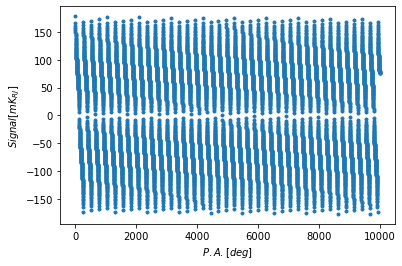

In [63]:
num = 10000
plt.figure(figsize=(7, 5))
#plt.plot(np.degrees(phi[:num]), tod.cache.reference("atm_I0")[:num]*10e-3, ".")
plt.figure(2)
plt.plot(np.degrees(pa[:num-1]), '.')
plt.xlabel("$P.A. [deg]$")
plt.ylabel("$Signal [ mK_{RJ} ]$");

## Beam convolution 
Thi convolution assumes perfectly gaussian beams. I assume the FWHM of the beam represents the $\sigma$ of the gauss function

In [64]:
res_Q = 0.6 # deg
speed = args.scanrate*np.cos(np.deg2rad(args.ces_el))  # deg/sec
f_sam = args.sample_rate # Hz

N_sample = int((res_Q / speed) * f_sam)

N_sample

5

In [65]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# Create the binned map

In [66]:
from numba import njit
@njit
def make_a_map(output_map, signals):

    hits = np.zeros(len(output_map), dtype=np.int64)
    for pix, signal in signals:
        for p,s in zip(pix, signal):
            output_map[p] += s
            hits[p] += 1
    output_map[hits != 0] /= hits[hits != 0]
    return hits

In [67]:
#from numba.typed import List

signals = list()
for obs in data.obs:
    for ch in data.obs[0]['tod'].detectors:
        t = moving_average(obs["tod"].cache.reference("atm_%s" % ch), N_sample)
        p = obs["tod"].cache.reference("pixels_%s" % ch)
        signals.append((p, t))

In [68]:
npix = 12*args.NSIDE**2

output_map = np.zeros(npix, dtype=np.double)
h = make_a_map(output_map, signals)

0.0 180.0 -180.0 180.0


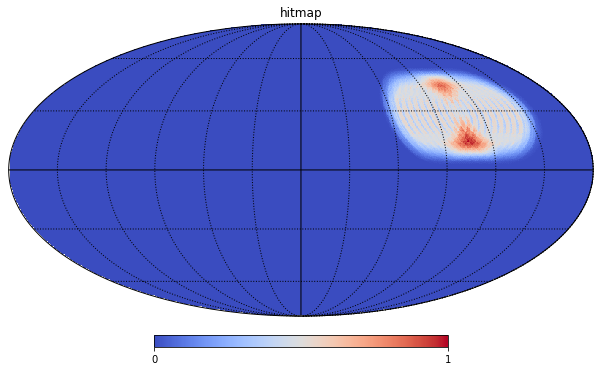

In [69]:
hp.mollview(h/np.amax(h), title="hitmap", nest=True, cmap='coolwarm')
hp.graticule()

0.0 180.0 -180.0 180.0


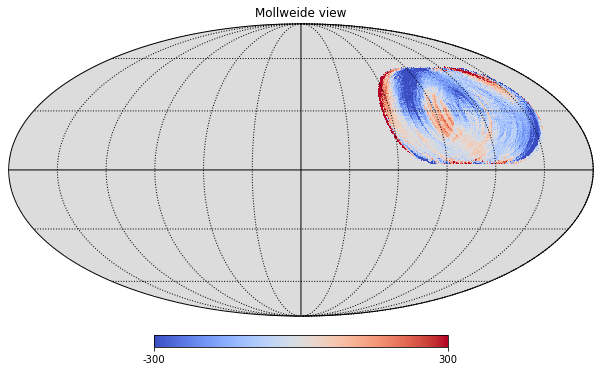

In [70]:
hp.mollview(output_map, nest=True, cmap="coolwarm", min=-300, max=300)
hp.graticule()

In [71]:
# Logica template

# convert to local
# -> pix
# hp.pix2ang -> alpha,delta
# ora + sito + (alpha,delta) -> Az, El 
# I(Az,El) = hpMap(pix)


77.8297096924424 102.17029030755758 -12.170290307557586 12.170290307557586


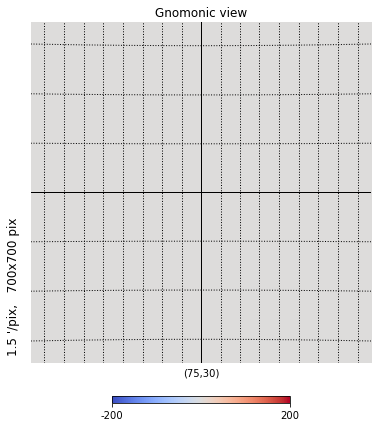

In [72]:
hp.gnomview(output_map, rot=(75,30), xsize=700, ysize=700, cmap="coolwarm", min=-200, max=200, nest=True)
hp.graticule()

In [73]:
O2 = moving_average(data.obs[0]['tod'].cache.reference('atm_O2')*10E-6, N_sample)
B4 = moving_average(data.obs[0]['tod'].cache.reference('atm_B4')*10E-6, N_sample)

R3 = moving_average(data.obs[0]['tod'].cache.reference('atm_R3')*10E-6, N_sample)
R0 = moving_average(data.obs[0]['tod'].cache.reference('atm_R0')*10E-6, N_sample)
R6 = moving_average(data.obs[0]['tod'].cache.reference('atm_R6')*10E-6, N_sample)

I0 = moving_average(data.obs[0]['tod'].cache.reference('atm_I0')*10E-6, N_sample)

I2 = moving_average(data.obs[0]['tod'].cache.reference('atm_I2')*10E-6, N_sample)
I1 = moving_average(data.obs[0]['tod'].cache.reference('atm_I1')*10E-6, N_sample)

Y3 = moving_average(data.obs[0]['tod'].cache.reference('atm_Y3')*10E-6, N_sample)
Y0 = moving_average(data.obs[0]['tod'].cache.reference('atm_Y0')*10E-6, N_sample)
Y6 = moving_average(data.obs[0]['tod'].cache.reference('atm_Y6')*10E-6, N_sample)

Text(0, 0.5, 'Signal $K_{RJ}$')

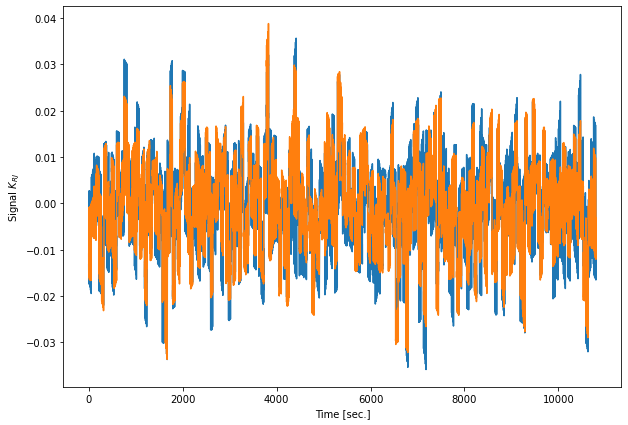

In [74]:
time = np.linspace(0, len(R3), len(R3))/20.0 # sec.

plt.figure(figsize=(10, 7))
plt.plot(time, R3, '-')
plt.plot(time, Y6, '-')

plt.xlabel("Time [sec.]")
plt.ylabel("Signal $K_{RJ}$")

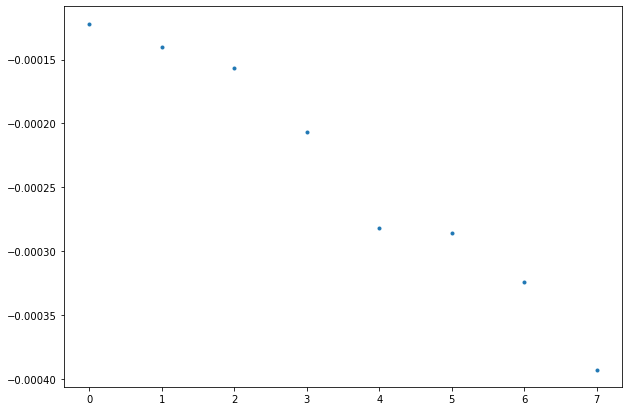

In [78]:
plt.figure(figsize=(10, 7))
plt.plot([0, 1, 2, 3, 4, 5, 6, 7], [np.median(R3), np.median(R0), np.median(R6), np.median(I2), np.median(I1), np.median(Y3), np.median(Y0), np.median(Y6)], '.')

In [76]:
from scipy.signal import periodogram
from scipy.signal import welch
from scipy.signal import correlate
import scipy.signal as signal


(1e-11, 0.1)

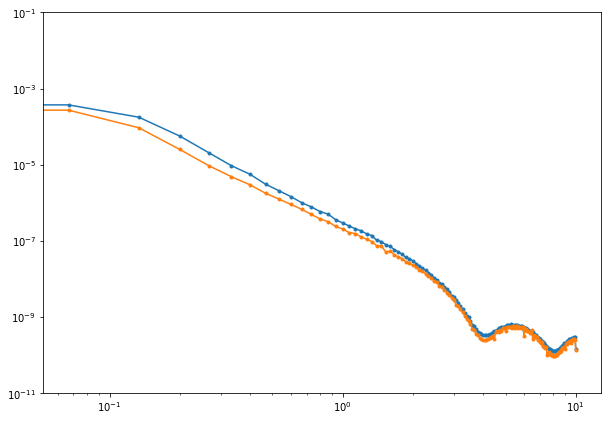

In [79]:
f1, p1 = welch(R3, fs=20.0, window='hamming', nperseg=300, noverlap=10, scaling='density')
f2, p2 = welch(Y6, fs=20.0, window=signal.get_window(('kaiser', 4.0), 300), nperseg=300, noverlap=20, scaling='density')

plt.figure(figsize=(10,7))
plt.loglog(f1, p1, '.-')
plt.loglog(f2, p2, '.-')

plt.ylim(1E-11, 1E-1)


In [80]:
import statsmodels.api as sm

In [81]:
cx = sm.tsa.stattools.ccf(O2, B4, adjusted=False)
cx2 = sm.tsa.stattools.ccf(R3, Y6, adjusted=False)

auto_cx = sm.tsa.stattools.ccf(I0, I0, adjusted=False)

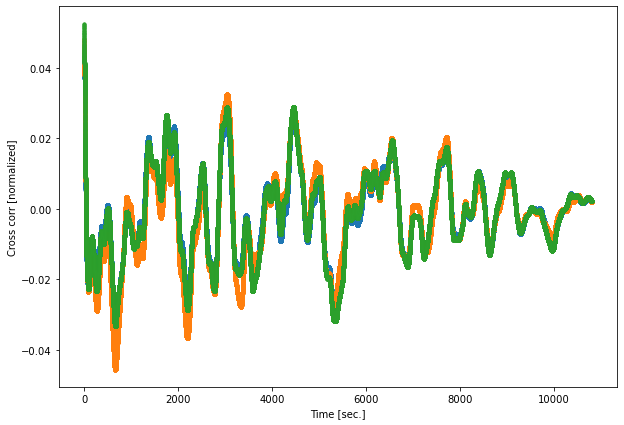

In [82]:
plt.figure(figsize=(10, 7))
plt.plot(np.linspace(0, len(cx), len(cx)-5000+1)/(20.0), moving_average(cx, 5000), '.')
plt.plot(np.linspace(0, len(cx2), len(cx2)-5000+1)/(20.0), moving_average(cx2, 5000), '.')

plt.xlabel("Time [sec.]")
plt.ylabel("Cross corr [normalized]")
plt.plot(np.linspace(0, len(auto_cx), len(auto_cx)-5000+1)/(20.0), moving_average(auto_cx, 5000), '.')

### Another way to evaluate the CX coef.

In [87]:
conv = np.correlate(R3, Y6, 'same')

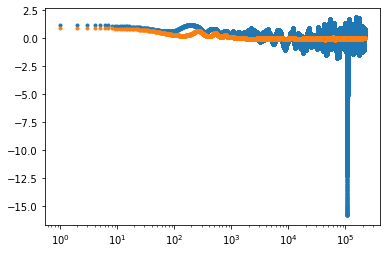

In [93]:
plt.semilogx(-conv, '.')
plt.plot(cx2, '.')

In [94]:
import scipy.signal as signal
cxx = correlate(R3, Y6, method='fft')
lags = signal.correlation_lags(len(R3), len(Y6))/20.0

(0.027055017515979086, 10799.75)

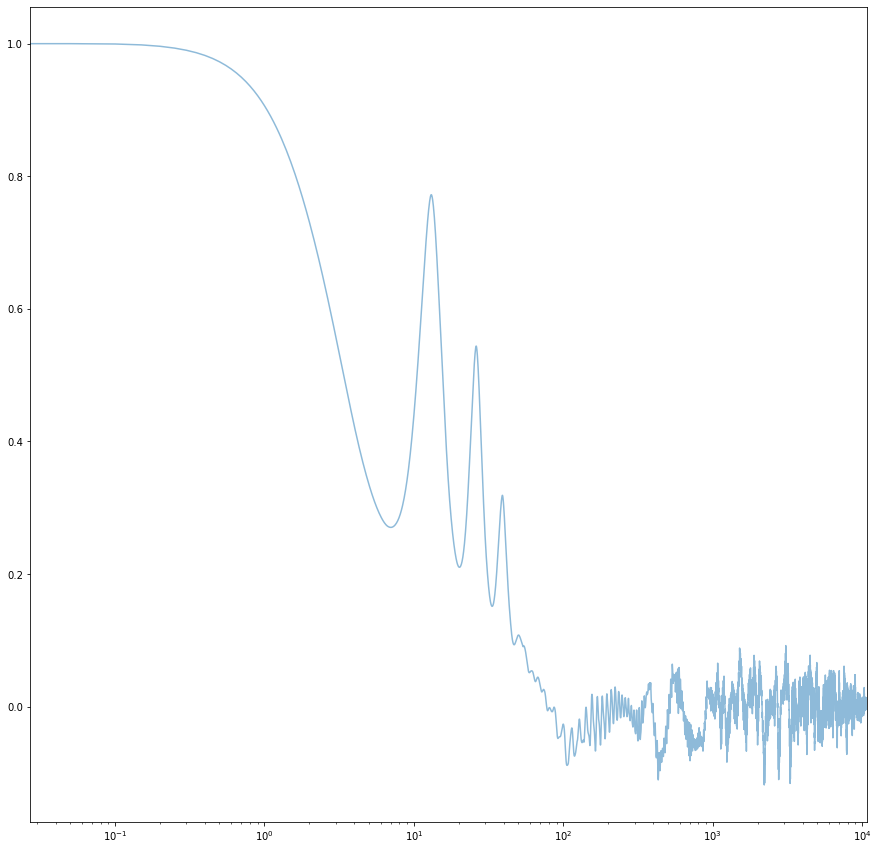

In [96]:
plt.figure(figsize=(15, 15))
plt.semilogx(lags, cxx/np.amax(cxx), alpha=0.5)
#plt.plot(np.linspace(0, len(cx2), len(cx2))/(20.0), cx2, alpha=0.4)

plt.xlim((0, lags[-1]))

In [97]:
cf, cp = welch(cx, fs=20, window="hamming", nperseg=50000, noverlap=15590)
cf2, cp2 = welch(cx2, fs=20, window="hamming", nperseg=50000, noverlap=15590)
cf_a, cp_a = welch(auto_cx, fs=20, window="hamming", nperseg=50000, noverlap=15590)

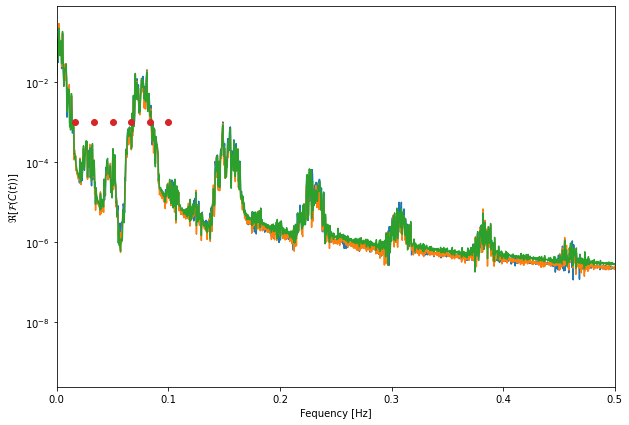

In [107]:
plt.figure(figsize=(10, 7))
plt.semilogy(cf, cp)
plt.semilogy(cf2, cp2)
plt.semilogy(cf_a, cp_a)
plt.xlim(0,0.5)

plt.ylabel("$\Re[\mathcal{F}(C(t))]$")
plt.xlabel("Fequency [Hz]")
#plt.xlim(0, 0.15)
#plt.ylim(1E-5, 1)

plt.plot([1/60, 2/60, 3/60, 4/60, 5/60, 6/60], [1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3], 'o')

In [108]:
az = obs['tod'].cache.reference('az')
alt = obs['tod'].cache.reference('el')

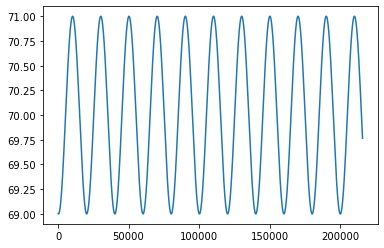

In [109]:
plt.plot(np.rad2deg(alt))